In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets, models
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    # imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(img))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [3]:
import torch.nn.functional as F


class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('resnet10t.c3_in1k', pretrained=True)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, 300
        )
        self.fc1 = nn.Linear(self.cnn.fc.out_features + 63, 100)
        self.fc2 = nn.Linear(100, 36)
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# load model 
# modelLoad = torch.load("resnet+feature.pth")
model = models.mobilenet_v3_small(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\intel/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [7]:
model_weight = []
conv_layer = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weight.append(model_children[i].weight)
        conv_layer.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weight.append(child.weight)
                    conv_layer.append(child)

print(f"Total convolution layers: {counter}")
print(conv_layer)

Total convolution layers: 2
[Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)]


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])

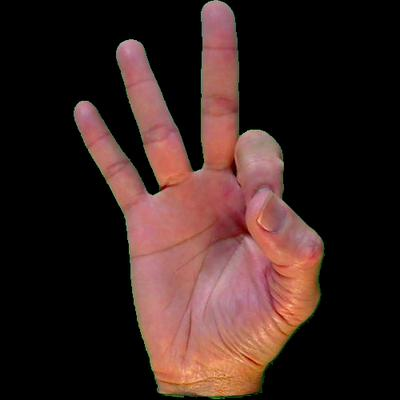

In [10]:
from PIL import Image
from IPython.display import display
img_path = "../asl_dataset/9/hand1_9_bot_seg_1_cropped.jpeg"
img = Image.open(img_path)

display(img)


In [11]:
image = train_transform(img)
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape after: torch.Size([1, 3, 100, 100])


In [12]:
outputs = []
names = []
for layer in conv_layer[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

RuntimeError: Given groups=1, weight of size [576, 96, 1, 1], expected input[1, 16, 50, 50] to have 96 channels, but got 16 channels instead

In [11]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(25, 25)
(25, 25)
(25, 25)
(25, 25)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(7, 7)
(7, 7)
(7, 7)
(7, 7)


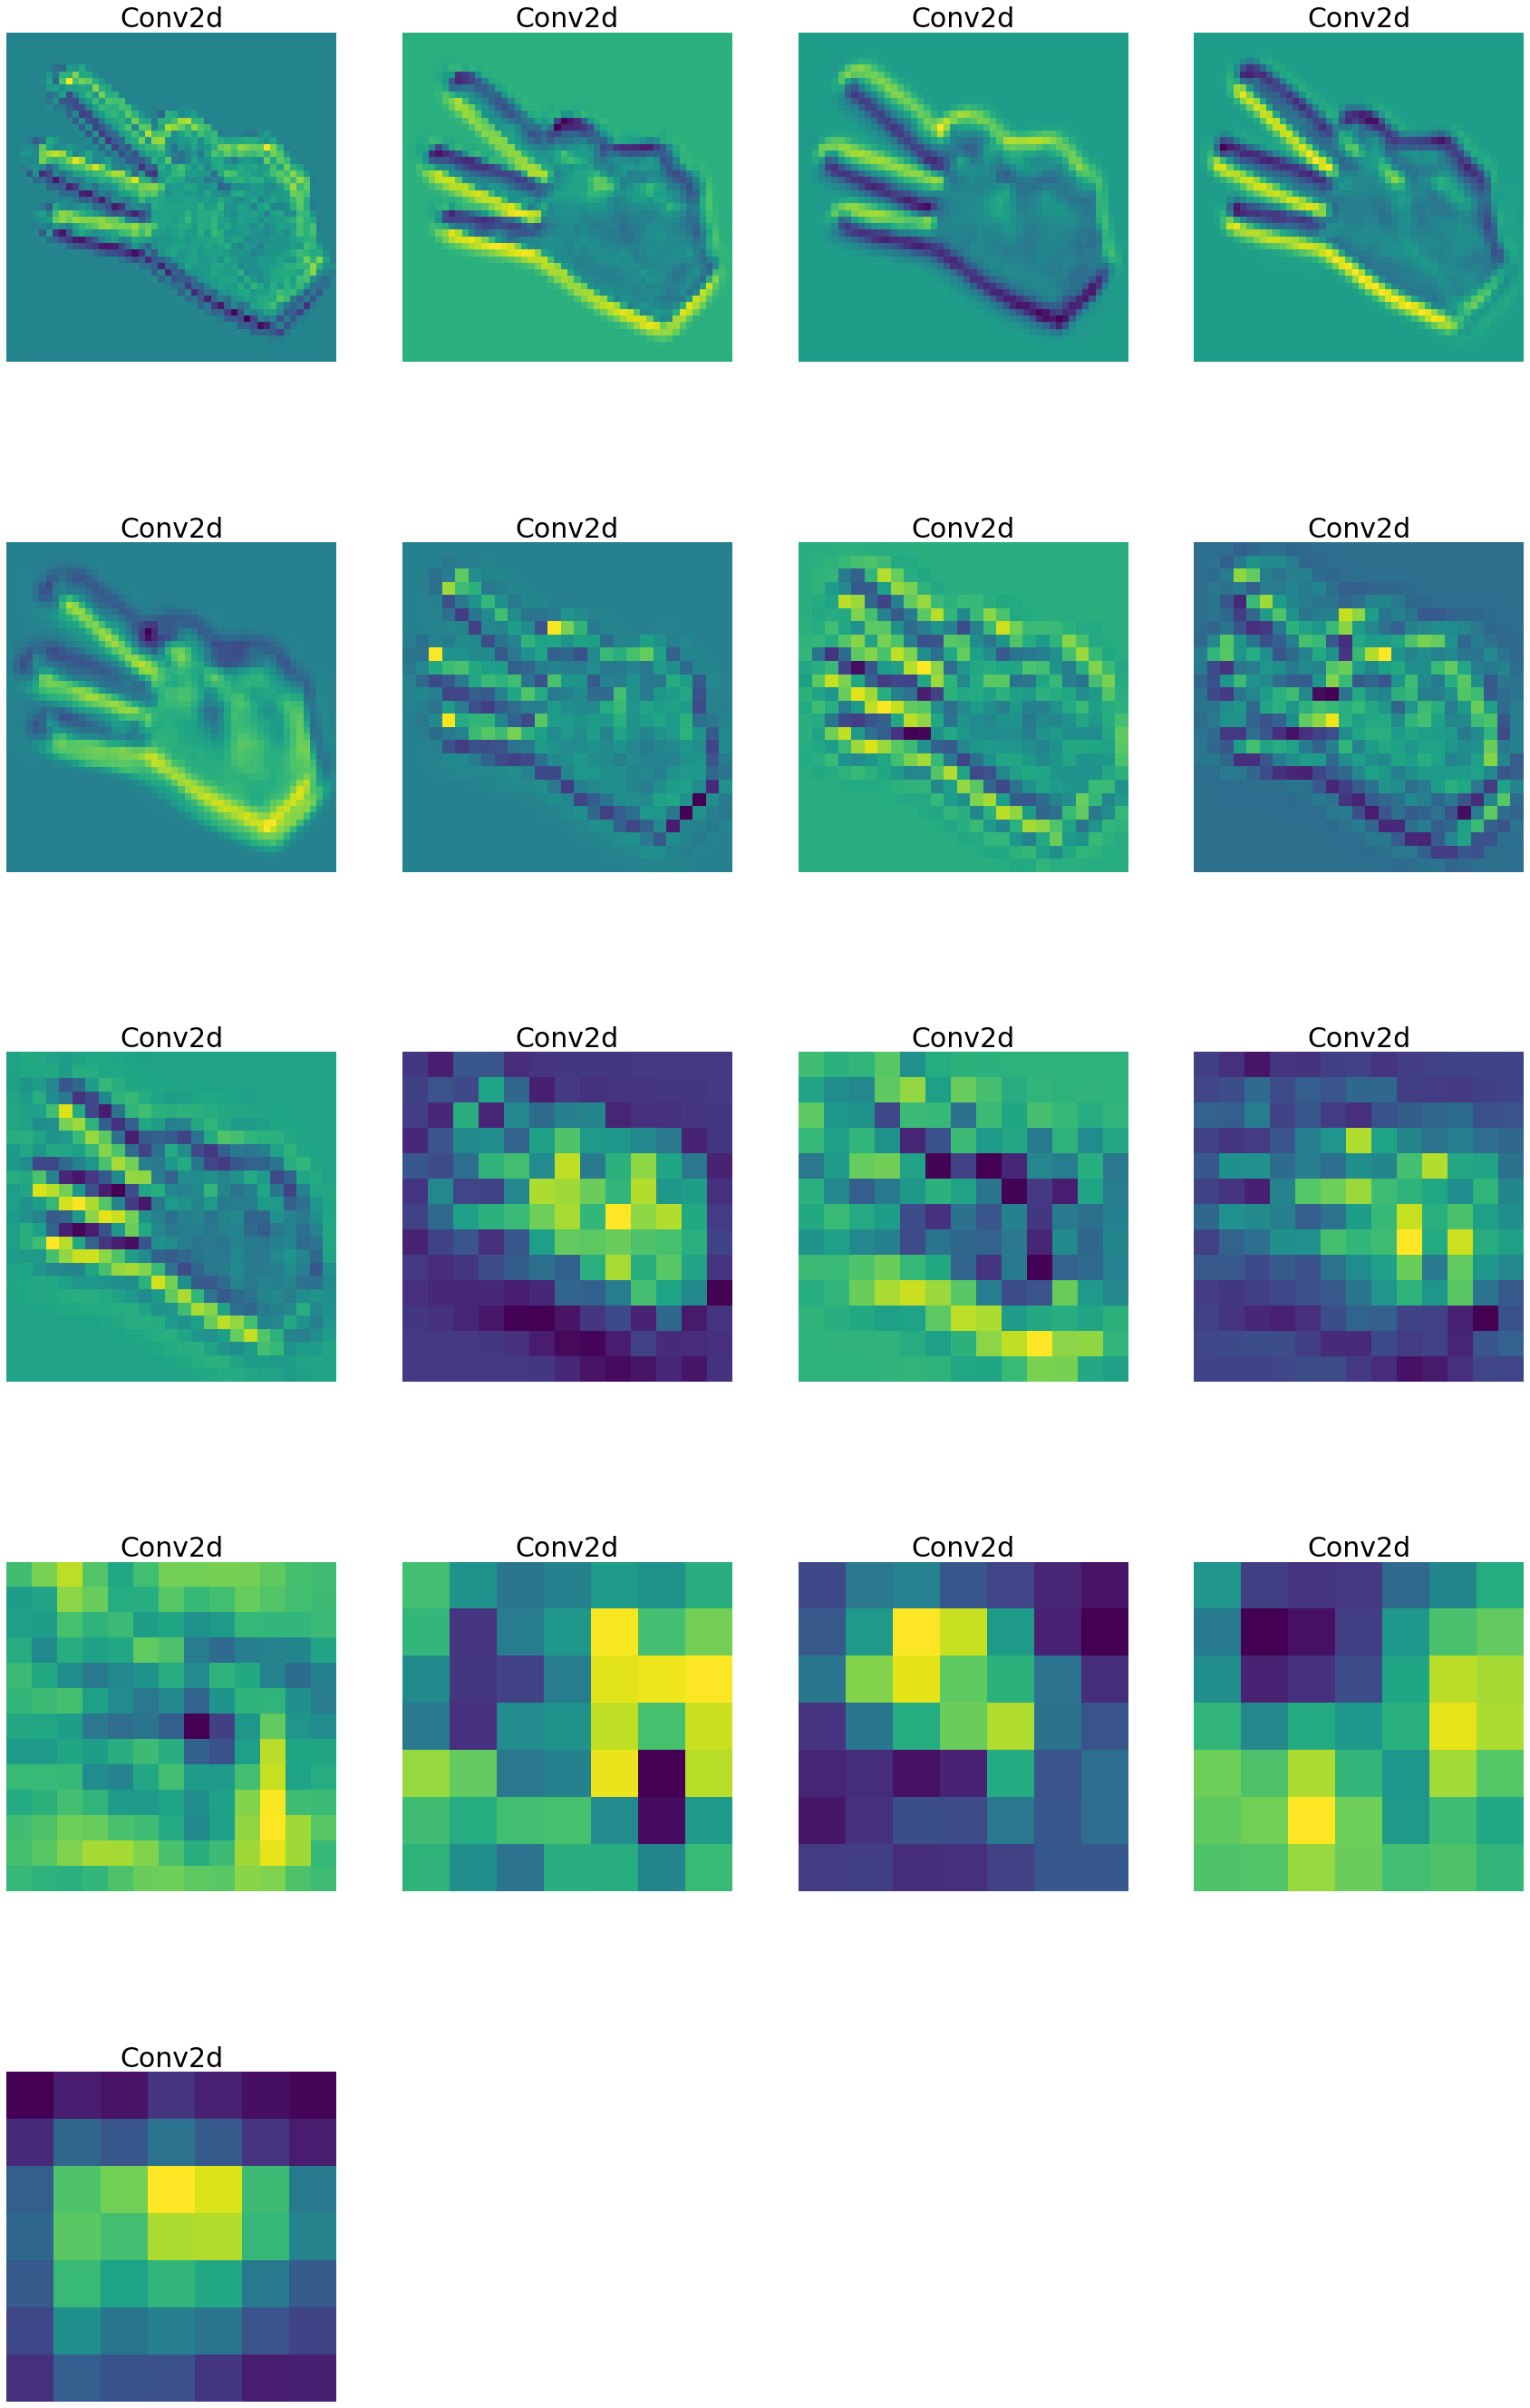

In [12]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [13]:
modelku = torch.load("resnet+feature.pth")
modelku.cuda()
modelku.eval()

MyModelDefault(
  (cnn): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [14]:
imageT = train_transform(img)
imageT = imageT.unsqueeze(0)
# print(f"Image shape after: {image.shape}")
imageT = imageT.to(device)
datafitur, err = handGesture(img)
datafitur = torch.as_tensor(datafitur).unsqueeze(0)
datafitur = datafitur.to(device)

output = modelku(imageT, datafitur)
print(output)

tensor([[-20.9319, -17.3240, -33.2623, -11.7464,  -5.1891,  -0.2354, -22.8294,
         -15.0410,  -7.8595,  10.5273, -10.3141, -12.8212, -30.3935, -13.0311,
          -7.6867,  -3.7974, -29.1186, -16.5423,  -3.4500, -14.4175, -17.4202,
         -14.6461, -18.0160, -13.3804, -27.6094, -27.8764, -31.4763, -22.1400,
         -13.9352,  -5.8081, -17.2461, -23.4887, -20.7811, -17.8454, -10.2548,
         -26.2008]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [15]:
# data folder
folderr = datasets.ImageFolder("../asl_dataset")
# mapp = torch.unique(folderr.targets, return_counts=True)
classdict = folderr.class_to_idx
new_dict = {value: key for key, value in classdict.items()}
new_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

In [16]:
max = torch.argmax(output)
max = max.item()

print("hasil deteksi: ")
new_dict[max]

hasil deteksi: 


'9'